In [1]:
from keras.utils import to_categorical                  # Converts a class vector (integers) to binary class matrix.
from keras_preprocessing.image import load_img
from keras.models import Sequential                     # A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import os
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm           # provides a simple and convenient way to add progress bars to loops and iterable objects

1. **Dense Layer (Fully Connected Layer)**:
   - The `Dense` layer is a fundamental building block in neural networks. It's also known as a fully connected layer.
   - Each neuron in this layer is connected to every neuron in the previous and subsequent layers.
   - It's used for learning complex patterns and relationships in the data.
   - Common activation functions used with `Dense` layers include **ReLU (Rectified Linear Unit)**, **sigmoid**, and **softmax**.
   - Useful for tasks like classification and regression.

2. **Conv2D Layer (2D Convolutional Layer)**:
   - The `Conv2D` layer performs 2D convolution on input data (usually images).
   - It uses a set of learnable filters (kernels) to extract features from local regions of the input.
   - Useful for tasks like image recognition, object detection, and segmentation.
   - Often followed by activation functions like ReLU.

3. **Dropout Layer**:
   - The `Dropout` layer helps prevent overfitting by randomly setting a fraction of input units to zero during training.
   - It encourages the network to learn robust features by preventing reliance on specific neurons.
   - Dropout reduces the risk of overfitting and improves generalization.

4. **Flatten Layer**:
   - The `Flatten` layer converts multidimensional input (e.g., feature maps from convolutional layers) into a 1D vector.
   - It's typically used to transition from convolutional layers to fully connected layers.
   - Necessary when passing data from convolutional layers to a dense layer.

5. **MaxPooling2D Layer**:
   - The `MaxPooling2D` layer downsamples feature maps by selecting the maximum value within a local region (pooling window).
   - Helps reduce spatial dimensions while retaining important features.
   - Commonly used after convolutional layers to reduce computational complexity and improve translation invariance.

In [2]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [3]:
def create_dataframe(dir):
    """
    Creates a dataframe containing image paths and corresponding labels.

    Args:
        dir (str): The directory path containing subdirectories of labeled images.

    Returns:
        tuple: A tuple containing two lists:
            - image_paths (list): List of image file paths.
            - labels (list): List of corresponding labels.
    """
    
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for image_name in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, image_name))
            labels.append(label)
        print(f'{dir}/{label} loaded')
    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = create_dataframe(TRAIN_DIR)   # Creating colums in the pandas dataframe

test = pd.DataFrame()
test['image'], test['label'] = create_dataframe(TEST_DIR)   # Creating colums in the pandas dataframe

images/train/angry loaded
images/train/disgust loaded
images/train/fear loaded
images/train/happy loaded
images/train/neutral loaded
images/train/sad loaded
images/train/surprise loaded
images/test/angry loaded
images/test/disgust loaded
images/test/fear loaded
images/test/happy loaded
images/test/neutral loaded
images/test/sad loaded
images/test/surprise loaded


In [5]:
print(train)

                                image     label
0            images/train\angry\0.jpg     angry
1            images/train\angry\1.jpg     angry
2           images/train\angry\10.jpg     angry
3        images/train\angry\10002.jpg     angry
4        images/train\angry\10016.jpg     angry
...                               ...       ...
28816  images/train\surprise\9969.jpg  surprise
28817  images/train\surprise\9985.jpg  surprise
28818  images/train\surprise\9990.jpg  surprise
28819  images/train\surprise\9992.jpg  surprise
28820  images/train\surprise\9996.jpg  surprise

[28821 rows x 2 columns]


In [6]:
print(test)

                              image     label
0       images/test\angry\10052.jpg     angry
1       images/test\angry\10065.jpg     angry
2       images/test\angry\10079.jpg     angry
3       images/test\angry\10095.jpg     angry
4       images/test\angry\10121.jpg     angry
...                             ...       ...
7061  images/test\surprise\9806.jpg  surprise
7062  images/test\surprise\9830.jpg  surprise
7063  images/test\surprise\9853.jpg  surprise
7064  images/test\surprise\9878.jpg  surprise
7065   images/test\surprise\993.jpg  surprise

[7066 rows x 2 columns]


In [7]:
def extract_features(images):
    """
    Extracts features from a list of images.

    Args:
        images (pd.DataFrame): A DataFrame containing image paths.
        

    Returns:
        np.ndarray: An array of image features. (Returns a 4D array of shape (num_images, 48, 48, 1))
    """
    
    # images is a pd.DataFrame['images']
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    
    # Dimension of the image is 48x48. Since the images are grayscale, the depth is 1
    features.reshape(len(features), 48, 48, 1)
    return features

In [8]:
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

  0%|          | 0/7066 [00:00<?, ?it/s]

In [9]:
# Normalization of the data

x_train = train_features/255.0
x_test = test_features/255.0

In [10]:
from sklearn.preprocessing import LabelEncoder
# One-hot encoding in machine learning is the conversion of categorical information into a format that may be fed into machine learning algorithms to 
# improve prediction accuracy. One-hot encoding is a common method for dealing with categorical data in machine learning.

# One-hot encoding in machine learning is the conversion of categorical information into a format that may be fed into
# machine learning algorithms to improve prediction accuracy. One-hot encoding is a common method for dealing with categorical data in machine learning.

le = LabelEncoder()
le.fit(train['label'])  # LabelEncoder.fit() takes a categorical column and converts/maps it to numerical values.

LabelEncoder()

In [11]:
# LabelEncoder.transform() transforms labels to normalized encoding.
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

# https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/
# a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix 
# which has binary values and has columns equal to the number of categories in the data.
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [12]:
# Creating the model
model = Sequential()

# The first layer is a convolutional layer with 32 filters, each with a size of 3x3, and a ReLU activation function.
# These layers are used for feature extraction
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layer with 128 neurons and a ReLU activation function.
# These are used for classification
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(7, activation='softmax'))


## Conv2D Layer:

The Conv2D layer stands for 2D convolution. It creates a convolution kernel that slides over the input data (usually an image) to produce a tensor of outputs.

- **Filters**: This parameter specifies the number of filters (also known as channels) in the convolution. Each filter learns different features from the input data. In your example, you’ve set it to 128.

The filters parameter determines the number of convolutional filters that the layer will learn during training.
- Each filter is a small matrix (usually 3x3 or 5x5) that slides over the input data (such as an image) to extract features.
- These filters are initialized with small random values and updated during training to minimize the loss.
- Over time, the filters learn to detect specific features, such as edges, textures, or patterns.
- For example, a filter might specialize in detecting vertical edges, while another focuses on diagonal lines.
- The more filters you have, the more diverse features the layer can learn.
- Layers early in the network architecture (closer to the input image) typically learn fewer filters, while deeper layers learn more filters12.
- So, when you define a Conv2D layer with a specific number of filters (e.g., Conv2D(64, kernel_size=(5, 5), activation='relu')), it means that the layer will learn 64 different filters.  These filters will automatically adapt during training to capture relevant features from the input data.

As for the output of the convolutional layer:

- If you apply this layer to a 32x32 RGB image, you’ll get 64 feature maps, each of size 28x28 (due to the 5x5 kernel and 1x1 stride).
- These feature maps represent the activation of each filter across the input image.
- Further layers (e.g., pooling, fully connected) combine information from these feature maps to make predictions or perform other tasks.

- **Kernel Size**: Determines the size of the convolution window. It can be specified as an integer or a tuple of two integers. Here, you’ve used a 3x3 kernel.
- **Strides**: Specifies the step size for the kernel as it moves across the input. A stride of (1, 1) means it moves one pixel at a time in both dimensions.
- **Padding**: Determines how the input is padded before applying the convolution. "valid" means no padding, while "same" pads the input to maintain the output size.
- **Activation**: An optional activation function applied to the output. In your case, it’s ReLU (Rectified Linear Unit), which introduces non-linearity.

## MaxPooling2D Layer:

The MaxPooling2D layer performs max pooling on the input data.
- **Pool Size**: Specifies the size of the pooling window. Here, it’s (2, 2), meaning it takes the maximum value from a 2x2 region.
Max pooling reduces the spatial dimensions of the feature maps, helping to capture important features while reducing computation.

## Dropout Layer:

The Dropout layer helps prevent overfitting by randomly setting a fraction of input units to zero during training.
The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different thinned networks.
- **Dropout Rate**: You’ve set it to 0.4, meaning 40% of the input units will be dropped during training.

In [13]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

### Optimizer: **Adam**
Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

### Loss: **Categorical Crossentropy**
We utilize categorical cross-entropy loss in multi-class classification tasks with more than two mutually exclusive classes. Similarly to the binary, this type of cross-entropy loss function quantifies the dissimilarity between the predicted probabilities and the true categorical labels.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 256)       0

In [15]:
# Training the model
model.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

# Epoch 10: Accuracy 0.55
# Epoch 50: Accuracy 0.62
# Epoch 70: Accuracy 0.6279
# Log: Model crashed after 72 epochs, retraining for 50 epochs since no notable progress made after additional epochs
# Epoch 50: Accuracy 0.6227

Epoch 1/50
226/226 [==============================] - 46s 121ms/step - loss: 1.8223 - accuracy: 0.2429 - val_loss: 1.8037 - val_accuracy: 0.2583
Epoch 2/50
226/226 [==============================] - 23s 100ms/step - loss: 1.7984 - accuracy: 0.2508 - val_loss: 1.7719 - val_accuracy: 0.2613
Epoch 3/50
226/226 [==============================] - 23s 102ms/step - loss: 1.7236 - accuracy: 0.2917 - val_loss: 1.6515 - val_accuracy: 0.3312
Epoch 4/50
226/226 [==============================] - 23s 103ms/step - loss: 1.6138 - accuracy: 0.3604 - val_loss: 1.4386 - val_accuracy: 0.4462
Epoch 5/50
226/226 [==============================] - 24s 107ms/step - loss: 1.5001 - accuracy: 0.4145 - val_loss: 1.3891 - val_accuracy: 0.4679
Epoch 6/50
226/226 [==============================] - 24s 104ms/step - loss: 1.4367 - accuracy: 0.4487 - val_loss: 1.3020 - val_accuracy: 0.5058
Epoch 7/50
226/226 [==============================] - 25s 109ms/step - loss: 1.3895 - accuracy: 0.4680 - val_loss: 1.2605 - val_ac

In [16]:
# Saving the model
model_json = model.to_json()
with open("emotiondetector.json", "w") as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

In [17]:
# Loading the model
from keras.models import model_from_json

json = open('emotiondetector.json', 'r')
model_json = json.read()
json.close()
model = model_from_json(model_json)
model.load_weights('emotiondetector.h5')

In [18]:
# 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [23]:
def ef(image):
    """
    Extracts features from an image.

    Args:
        image (str): The path to the image file.

    Returns:
        np.ndarray: An array of image features. (Extracting a single image)
    """
    img = load_img(image, color_mode='grayscale')
    feature = np.array(img)
    feature = feature.reshape(1, 48, 48, 1)
    return feature/255.0

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

1/1 [==============================] - 0s 60ms/step
sad


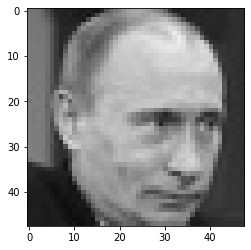

In [33]:
test_image = 'images/test/angry/65.jpg'
img = ef(test_image)

# Predicting with the model
pred = model.predict(img)
pred_label = label[np.argmax(pred)]
print(pred_label)
plt.imshow(load_img(test_image))
# Predicts 'sad'
# I mean, can you really blame it?